In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import mylib
import pymaster as nmt
from importlib import reload
from tqdm import tqdm

In [2]:
nside = 512
npix = 12*nside**2
lmax = 3*nside-1
n_sims = 10

In [3]:
reload(mylib)
# ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
ell_input, TT, EE, BB, TE = np.loadtxt('totcls_lensed_r0p1.txt', unpack=True)

# input_cls = np.array([TT, np.zeros_like(BB), BB, TE]) #no EE
input_cls = np.array([TT, EE, BB, TE])
input_cls /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)
ell_input = ell_input[:lmax+1]
c2d = ell_input*(ell_input+1)/2/np.pi

noise_fit_T = np.load('noise_fit_T.npy')
noise_fit_P = np.load('noise_fit_P.npy')
noise_cl_T = mylib.noise_model(np.arange(lmax+1), noise_fit_T[0], noise_fit_T[1], noise_fit_T[2])
noise_cl_P = mylib.noise_model(np.arange(lmax+1), noise_fit_P[0], noise_fit_P[1], noise_fit_P[2])
noise_cls_planck = np.array([noise_cl_T, noise_cl_P, np.zeros(lmax+1), np.zeros(lmax+1)])
# noise_cls_planck = np.array([noise_cl_T, noise_cl_P, noise_cl_P, np.zeros(lmax+1)])

noise_cl_T = mylib.depth2nl(np.sqrt(noise_fit_T[0])/25, 0, lmax)
noise_cl_P = mylib.depth2nl(np.sqrt(noise_fit_P[0])/25, 0, lmax)
noise_cls_lb = np.array([noise_cl_T, noise_cl_P, np.zeros(lmax+1), np.zeros(lmax+1)])
# noise_cls_lb = np.array([noise_cl_T, noise_cl_P, noise_cl_P, np.zeros(lmax+1)])

/tmp/ipykernel_27553/2350908085.py:7: RuntimeWarning: invalid value encountered in true_divide
  input_cls /= ell_input*(ell_input+1)/2/np.pi
/scratch/yuyang/destripe/methods.py:66: RuntimeWarning: divide by zero encountered in power
  model = n * (l/knee)**alpha + n


7.317829132080078


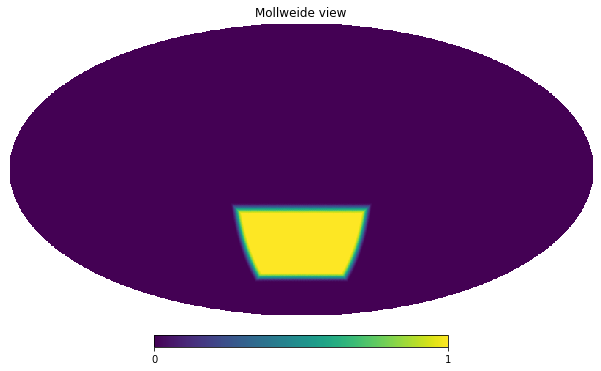

In [4]:
reload(mylib)
mask = mylib.get_mask(nside)
pix = np.where(mask!=0)[0]
mask_apo = nmt.mask_apodization(mask, 6, apotype='C2')
hp.mollview(mask_apo)
print(len(mask_apo[(mask_apo!=0)])/npix *100)

In [5]:
reload(mylib)
sigmab = hp.nside2resol(nside)
fwhm = mylib.sigma2fwhm(sigmab)
bl = mylib.get_bl(nside)
mll = mylib.get_mll(mask_apo, nside, pol=False)
b = nmt.NmtBin.from_nside_linear(nside, 32)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi

In [6]:
input_map = mask*hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)

In [7]:
filtered_map = mylib.filt(input_map, pix)

In [8]:
noise_map = hp.synfast(noise_cls_lb, nside, new=True)
wienered_external_map = mylib.wiener_filter(input_map + noise_map, input_cls_noBB, noise_cls_lb)

In [9]:
lost_map = wienered_external_map - mylib.filt(wienered_external_map, pix)
restored_map = filtered_map + lost_map

In [10]:
f = nmt.NmtField(mask_apo, [restored_map[1], restored_map[2]], beam=bl, purify_b=True)
cl_rest = nmt.compute_full_master(f, f, b)

In [11]:
f = nmt.NmtField(mask_apo, [filtered_map[1], filtered_map[2]], beam=bl, purify_b=True)
cl_filt = nmt.compute_full_master(f, f, b)

In [12]:
f = nmt.NmtField(mask_apo, [input_map[1], input_map[2]], beam=bl, purify_b=True)
cl = nmt.compute_full_master(f, f, b)

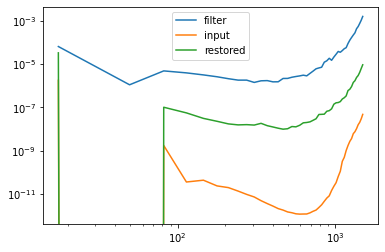

In [13]:
plt.plot(ells, cl_filt[3], label='filter')
plt.plot(ells, cl[3], label='input')
plt.plot(ells, cl_rest[3], label='restored')

plt.loglog()
plt.legend()

In [26]:
#Filter transfer
reload(mylib)
pcl_bb = np.zeros((n_sims, lmax+1))
pcl_ee = np.zeros((n_sims, lmax+1))

for i in tqdm(range(n_sims)):
    input_map_bb = hp.synfast(input_cls[2], nside, fwhm=fwhm)
    input_map_ee = hp.synfast(input_cls[1], nside, fwhm=fwhm)

    filtered_bb = mask_apo * mylib.filt(input_map_bb, pix)
    filtered_ee = mask_apo * mylib.filt(input_map_ee, pix)

    pcl_bb[i] = hp.anafast(filtered_bb)
    pcl_ee[i] = hp.anafast(filtered_ee)

pcl_bb = np.mean(pcl_bb, axis=0)
pcl_ee = np.mean(pcl_ee, axis=0)

100%|████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


In [27]:
flbb = mylib.get_fl(input_cls[2], pcl_bb, bl, mll)
flee = mylib.get_fl(input_cls[1], pcl_ee, bl, mll)

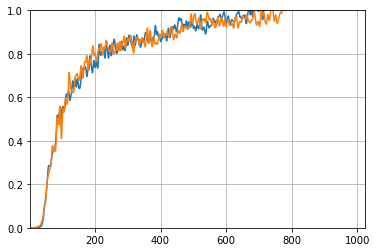

In [46]:
plt.plot(flbb)
plt.plot(flee)
plt.ylim([0,1])
plt.xlim([2, 2*nside])
plt.grid()

In [12]:
# reload(mylib)
# leakage = np.zeros((n_sims, lmax+1))

# for i in tqdm(range(n_sims)):
#     input_map = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
#     pcl_bb = hp.anafast(mask_apo * input_map, nspec=3)[2]
#     filtered_input_map = mask_apo*mylib.filt(input_map, pix)
#     pcl_bb_filt = hp.anafast(filtered_input_map, nspec=3)[2]/flbb
#     leakage[i] = pcl_bb_filt - pcl_bb
    
# leakage = np.mean(leakage, axis=0)

In [13]:
# plt.plot(leakage)
# plt.xlim([2, 2*nside])
# plt.grid()
# plt.loglog()

In [41]:
def compute_master(f1, f2, w, leakage=None):
    coupled_cell = nmt.compute_coupled_cell(f1, f2)
    if leakage is not None:
        coupled_cell[3] -= leakage
    return w.decouple_cell(coupled_cell)

In [42]:
w = nmt.NmtWorkspace()
f = nmt.NmtField(mask_apo, [np.empty(npix), np.empty(npix)], beam=bl, purify_b=True)
w.compute_coupling_matrix(f, f, b)

In [43]:
cl_filtered = np.zeros((n_sims, 4, len(ells)))
cl_restored_planck = np.zeros((n_sims, 4, len(ells)))
cl_restored_lb = np.zeros((n_sims, 4, len(ells)))
cl_noiseless = np.zeros((n_sims, 4, len(ells)))

for i in tqdm(range(n_sims)):
    input_map = mask*hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)

    #FILTER BIN
    filtered_input_map = mask*mylib.filt(input_map, pix)
    f = nmt.NmtField(mask_apo, [filtered_input_map[1], filtered_input_map[2]], purify_b=True)
    cl_filtered[i] = compute_master(f, f, w, None)
    
    #Noiseless
    lost_map = input_map - filtered_input_map
    restored_map = filtered_input_map + lost_map
    f = nmt.NmtField(mask_apo, [restored_map[1], restored_map[2]], purify_b=True)
    cl_noiseless[i] = compute_master(f, f, w, None) 
    
    #PLANCK
    external_map = input_map + hp.synfast(noise_cls_planck, nside, new=True)
    wienered_external_map = mylib.wiener_filter(external_map, input_cls, noise_cls_planck)
    filtered_external_map = mylib.filt(wienered_external_map, pix)
    lost_map = wienered_external_map - filtered_external_map
    restored_map = mask * (filtered_input_map + lost_map)
    f = nmt.NmtField(mask_apo, [restored_map[1], restored_map[2]], purify_b=True)
    cl_restored_planck[i] = compute_master(f, f, w, None)
    
    #LITEBIRD
    external_map = input_map + hp.synfast(noise_cls_lb, nside, new=True)
    wienered_external_map = mylib.wiener_filter(external_map, input_cls, noise_cls_lb)
    filtered_external_map = mylib.filt(wienered_external_map, pix)
    lost_map = wienered_external_map - filtered_external_map
    restored_map = mask * (filtered_input_map + lost_map)
    f = nmt.NmtField(mask_apo, [restored_map[1], restored_map[2]], purify_b=True)
    cl_restored_lb[i] = compute_master(f, f, w, None)
    
mean_filtered = c2db*np.mean(cl_filtered, axis=0)
std_filtered = c2db*np.std(cl_filtered, axis=0)
mean_restored_planck = c2db*np.mean(cl_restored_planck, axis=0) 
std_restored_planck = c2db*np.std(cl_restored_planck, axis=0)
mean_restored_lb = c2db*np.mean(cl_restored_lb, axis=0) 
std_restored_lb = c2db*np.std(cl_restored_lb, axis=0)
mean_noiseless = c2db*np.mean(cl_noiseless, axis=0) 
std_noiseless = c2db*np.std(cl_noiseless, axis=0)

100%|████████████████████████████████████████████| 10/10 [04:11<00:00, 25.19s/it]


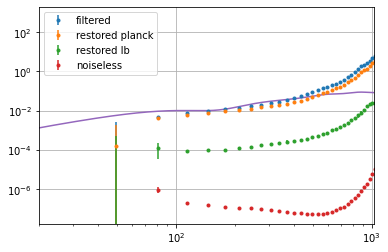

In [44]:
ind = 3
plt.errorbar(ells, mean_filtered[ind], yerr=std_filtered[ind], fmt='.', label='filtered')
plt.errorbar(ells, mean_restored_planck[ind], yerr=std_restored_planck[ind], fmt='.', label='restored planck')
plt.errorbar(ells, mean_restored_lb[ind], yerr=std_restored_lb[ind], fmt='.', label='restored lb')
plt.errorbar(ells, mean_noiseless[ind], yerr=std_noiseless[ind], fmt='.', label='noiseless')
plt.plot(BB)
# plt.plot(EE)
plt.legend()
# plt.ylim([-1,1])
plt.xlim([20,2*nside])
plt.loglog()
plt.grid()

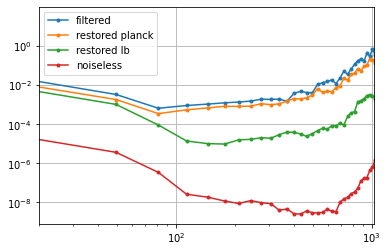

In [47]:
#Baseline + pess SAT 145 GHz. l_knee = 50/25, n= 3.3/2.1
# SAT_base = mylib.noise_model(np.arange(lmax+1), (3.3*np.pi/(60*180))**2, 50, -3)
# SAT_target = mylib.noise_model(np.arange(lmax+1), (2.1*np.pi/(60*180))**2, 25, -3)
# plt.plot(c2d*SAT_base, label='SAT 145 baseline')
# plt.plot(c2d*SAT_target, label='SAT 145 target')

plt.plot(ells, std_filtered[3], marker='.', label='filtered')
plt.plot(ells, std_restored_planck[3], marker='.',label='restored planck')
plt.plot(ells, std_restored_lb[3], marker='.',label='restored lb')
plt.plot(ells, std_noiseless[3], marker='.',label='noiseless')

plt.xlim([20,2*nside])
plt.loglog()
plt.legend()
plt.grid()